In [110]:
!pip install ucimlrepo
!pip install xgboost
!pip install --upgrade xgboost

In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
import xgboost as xgb

**Procesamiento de los datos:**

In [112]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
Xair = air_quality.data.features
yair = air_quality.data.targets

In [113]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

In [114]:
# Cambiar el nombre de la variable C6H6(GT)
df = df.rename(columns={'C6H6(GT)': 'C6H6'})

In [115]:
#Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [116]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [117]:
# Reemplazar los valores -200 en la columna T con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].ffill(inplace=True)
df['T'].ffill(inplace=True)
df['RH'].ffill(inplace=True)

In [118]:
print(df.head())


                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6


**Modelo Ensamble XGBoost**

In [119]:
# Train/Test  90% y 10% se toma esta división para después poder usar el mismo % en las 5 grupos de cross validation
df_T_train = df['T'].iloc[:round(len(df['T'])*.9)]
df_T_test = df['T'].iloc[round(len(df['T'])*.9):]
print(len(df_T_train), len(df_T_test))

8421 936


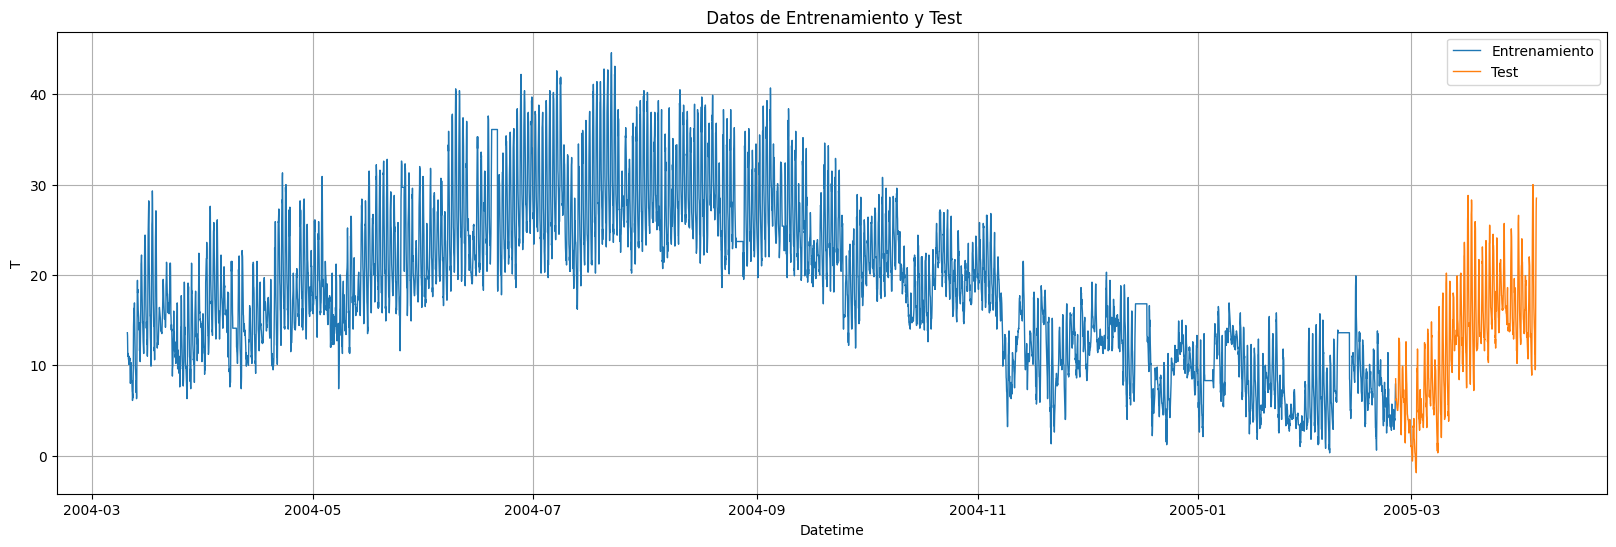

In [120]:
# Gráficos train y test
plt.figure(figsize=(20, 6))

plt.plot(df_T_train, label='Entrenamiento', linestyle='-', linewidth=1)
plt.plot(df_T_test, label='Test', linestyle='-', linewidth=1)

plt.title(' Datos de Entrenamiento y Test')
plt.xlabel('Datetime')
plt.ylabel('T')

plt.legend()
plt.grid(True)
plt.show()

**Cross Validation**

In [121]:
from sklearn.model_selection import TimeSeriesSplit

In [122]:
#Se usa la función TimeSeriesSplit para la separación de los datos para el cross validatio
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24) #Se deja un gap de24 hs entre cada unos de los 5 grupos de datos
df = df.sort_index() # ordena las filas del DataFrame df según los valores del índice

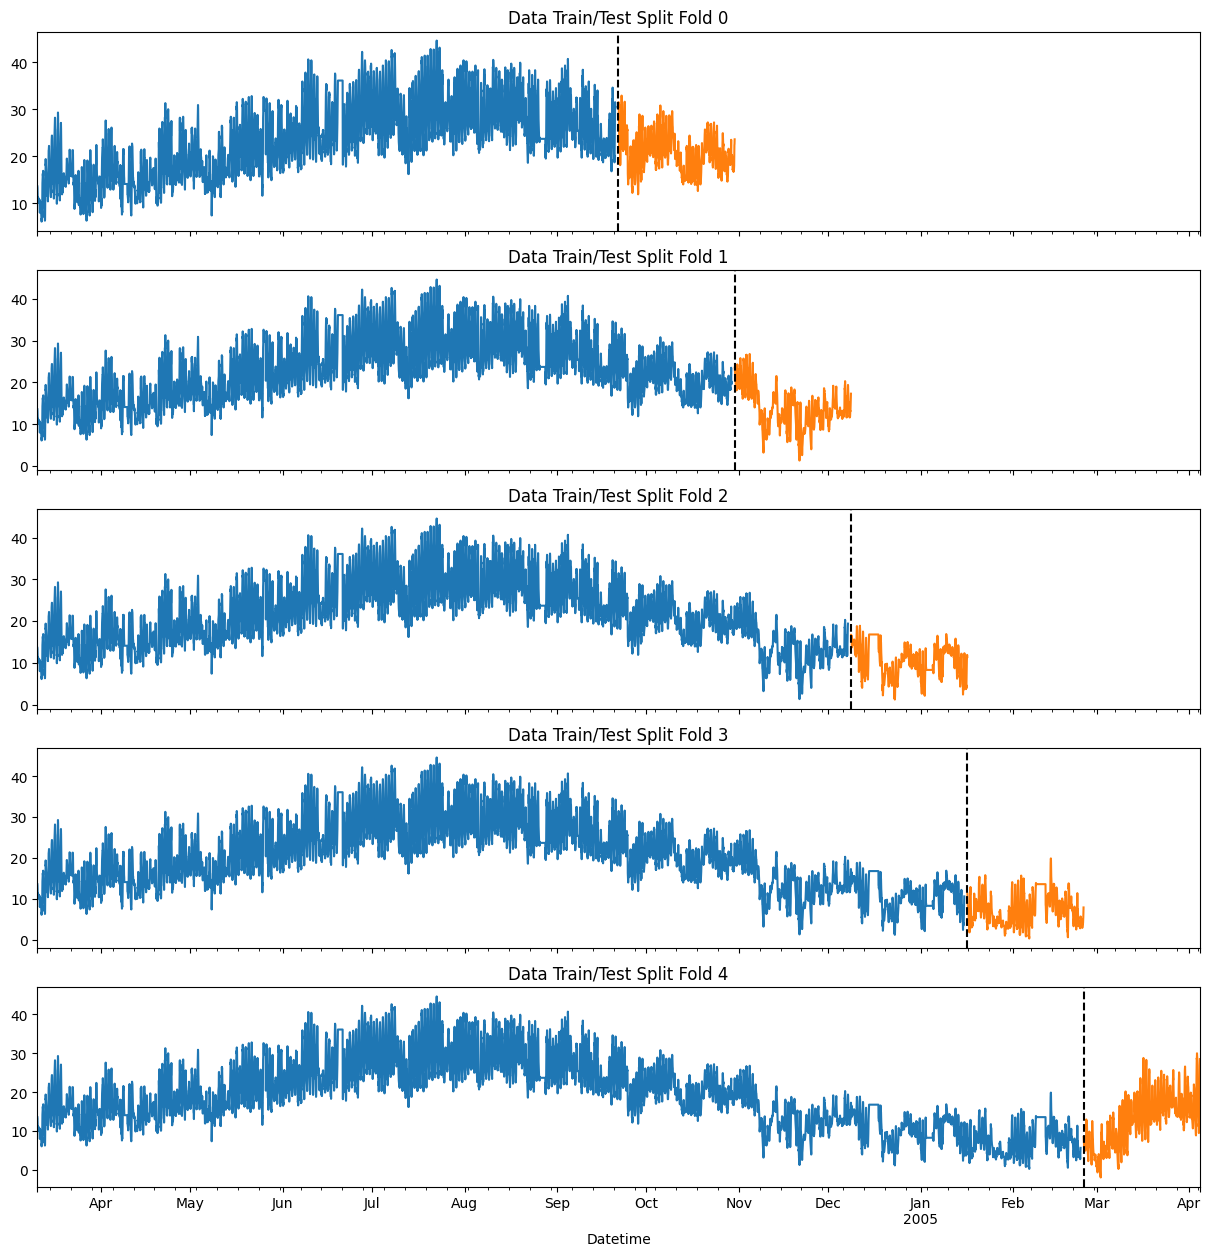

In [123]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df['T']):
    train = df['T'].iloc[train_idx]
    val = df['T'].iloc[val_idx]
    train.plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val.plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [124]:
#Cross validation manteniendo el orden temporal de los datos

for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 4650 4651 4652]
  Test:  index=[4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689 4690
 4691 4692 4693 4694 4695 4696 4697 4698 4699 4700 4701 4702 4703 4704
 4705 4706 4707 4708 4709 4710 4711 4712 4713 4714 4715 4716 4717 4718
 4719 4720 4721 4722 4723 4724 4725 4726 4727 4728 4729 4730 4731 4732
 4733 4734 4735 4736 4737 4738 4739 4740 4741 4742 4743 4744 4745 4746
 4747 4748 4749 4750 4751 4752 4753 4754 4755 4756 4757 4758 4759 4760
 4761 4762 4763 4764 4765 4766 4767 4768 4769 4770 4771 4772 4773 4774
 4775 4776 4777 4778 4779 4780 4781 4782 4783 4784 4785 4786 4787 4788
 4789 4790 4791 4792 4793 4794 4795 4796 4797 4798 4799 4800 4801 4802
 4803 4804 4805 4806 4807 4808 4809 4810 4811 4812 4813 4814 4815 4816
 4817 4818 4819 4820 4821 4822 4823 4824 4825 4826 4827 4828 4829 4830
 4831 4832 4833 4834 4835 4836 4837 4838 4839 4840 4841 4842 4843 4844
 4845 4846 4847 4848 4849 4850 4851 4852 4853 4854 4855 4856 4857 4858
 48

**Modelo 7:**

In [174]:
#Creación de features basadas en el índice tiempo para captar las estacionalidades

def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour #almacena en una columna nueva la hora
    df['dayofweek'] = df.index.dayofweek #almacena en una columna nueva el día de la semana
    df['year'] = df.index.year #año
    df['dayofyear'] = df.index.dayofyear #dia del año: de 1 a 365
    return df


In [175]:
df = create_features(df)
print(df.head(5))

                     C6H6     T    RH  hour  dayofweek  year  dayofyear  \
Datetime                                                                  
2004-03-10 18:00:00  11.9  13.6  48.9    18          2  2004         70   
2004-03-10 19:00:00   9.4  13.3  47.7    19          2  2004         70   
2004-03-10 20:00:00   9.0  11.9  54.0    20          2  2004         70   
2004-03-10 21:00:00   9.2  11.0  60.0    21          2  2004         70   
2004-03-10 22:00:00   6.5  11.2  59.6    22          2  2004         70   

                     lag_24  lag_168  lag_720  
Datetime                                       
2004-03-10 18:00:00     NaN      NaN      NaN  
2004-03-10 19:00:00     NaN      NaN      NaN  
2004-03-10 20:00:00     NaN      NaN      NaN  
2004-03-10 21:00:00     NaN      NaN      NaN  
2004-03-10 22:00:00     NaN      NaN      NaN  


In [176]:
#Agregado de lags ayuda a captar la estacionaliad
def add_lags(df):
    df['lag_24'] = df['T'].shift(24) #estacionalidad de 1 día
    df['lag_168'] = df['T'].shift(168) #estacionalidad de 7 días
    df['lag_720'] = df['T'].shift(720) #estacionalidad de 20 días

    return df

# Aplicar la función al DataFrame
df = add_lags(df)
print(df.tail(5))

                     C6H6     T    RH  hour  dayofweek  year  dayofyear  \
Datetime                                                                  
2005-04-04 10:00:00  13.5  21.9  29.3    10          0  2005         94   
2005-04-04 11:00:00  11.4  24.3  23.7    11          0  2005         94   
2005-04-04 12:00:00  12.4  26.9  18.3    12          0  2005         94   
2005-04-04 13:00:00   9.5  28.3  13.5    13          0  2005         94   
2005-04-04 14:00:00  11.9  28.5  13.1    14          0  2005         94   

                     lag_24  lag_168  lag_720  
Datetime                                       
2005-04-04 10:00:00    21.1     17.8     10.0  
2005-04-04 11:00:00    24.0     20.8     13.0  
2005-04-04 12:00:00    26.5     21.6     14.0  
2005-04-04 13:00:00    28.7     23.1     13.3  
2005-04-04 14:00:00    28.5     23.6     13.4  


*Entrenamiento:*

In [222]:
df = df.sort_index()

In [223]:
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24)

In [224]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek','year', 'C6H6', 'RH',
                'lag_24','lag_168','lag_720']
    TARGET = 'T'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators=500, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)   # Muestra información de entrenamiento cada 100 iteraciones

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:7.64152	validation_1-rmse:4.88079
[100]	validation_0-rmse:3.76086	validation_1-rmse:2.94453
[200]	validation_0-rmse:2.43918	validation_1-rmse:2.68692
[300]	validation_0-rmse:2.02800	validation_1-rmse:2.55821
[400]	validation_0-rmse:1.85381	validation_1-rmse:2.46125
[499]	validation_0-rmse:1.76239	validation_1-rmse:2.37563
[0]	validation_0-rmse:7.23844	validation_1-rmse:10.37782
[100]	validation_0-rmse:3.67381	validation_1-rmse:6.45371
[200]	validation_0-rmse:2.46585	validation_1-rmse:5.70663
[300]	validation_0-rmse:2.07425	validation_1-rmse:5.40963
[400]	validation_0-rmse:1.91102	validation_1-rmse:5.23587
[499]	validation_0-rmse:1.82217	validation_1-rmse:5.19315
[0]	validation_0-rmse:7.64043	validation_1-rmse:11.73128
[100]	validation_0-rmse:3.89938	validation_1-rmse:6.45734
[200]	validation_0-rmse:2.71420	validation_1-rmse:4.52373
[300]	validation_0-rmse:2.30347	validation_1-rmse:3.83111
[400]	validation_0-rmse:2.13957	validation_1-rmse:3.55986
[499]	validation_0

In [225]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.6184
Fold scores:[2.3756284541878343, 5.193152270863008, 3.4580013284331326, 4.542590438652423, 2.5223944952389568]


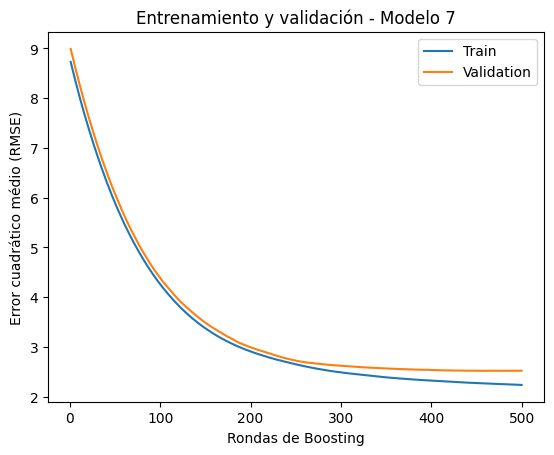

In [226]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación - Modelo 7')
plt.legend()
plt.show()

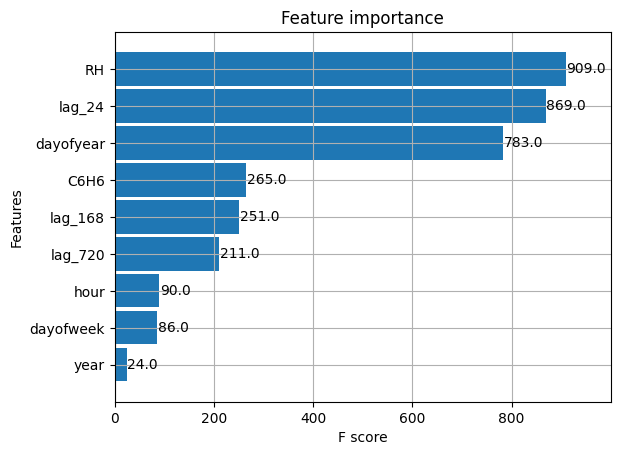

In [227]:
#Importancia de las variables
_ = plot_importance(reg, height=0.9)

In [228]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 6.362473989611792
Mean Absolute Error (MAE): 1.9754884522185368
Root Mean Squared Error (RMSE): 2.5223944952389568
RMSE Score on Test set: 2.52


In [229]:
y_pred = reg.predict(X_val)
val['prediction'] = reg.predict(X_val)
val

<ipython-input-229-2df80bd8730d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


,C6H6,T,RH,hour,dayofweek,year,dayofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,
2005-02-24 15:00:00,10.7,8.5,66.3,15,3,2005,55,5.6,8.9,4.5,6.133223
2005-02-24 16:00:00,13.3,7.6,70.8,16,3,2005,55,5.4,9.0,5.1,6.060047
2005-02-24 17:00:00,13.2,7.2,72.4,17,3,2005,55,4.9,9.3,5.0,5.353911
2005-02-24 18:00:00,17.5,6.7,74.2,18,3,2005,55,4.8,8.4,4.3,5.131666
2005-02-24 19:00:00,17.7,6.1,75.8,19,3,2005,55,4.8,7.6,4.3,4.667797
...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,13.5,21.9,29.3,10,0,2005,94,21.1,17.8,10.0,21.742996
2005-04-04 11:00:00,11.4,24.3,23.7,11,0,2005,94,24.0,20.8,13.0,27.271534
2005-04-04 12:00:00,12.4,26.9,18.3,12,0,2005,94,26.5,21.6,14.0,28.275154


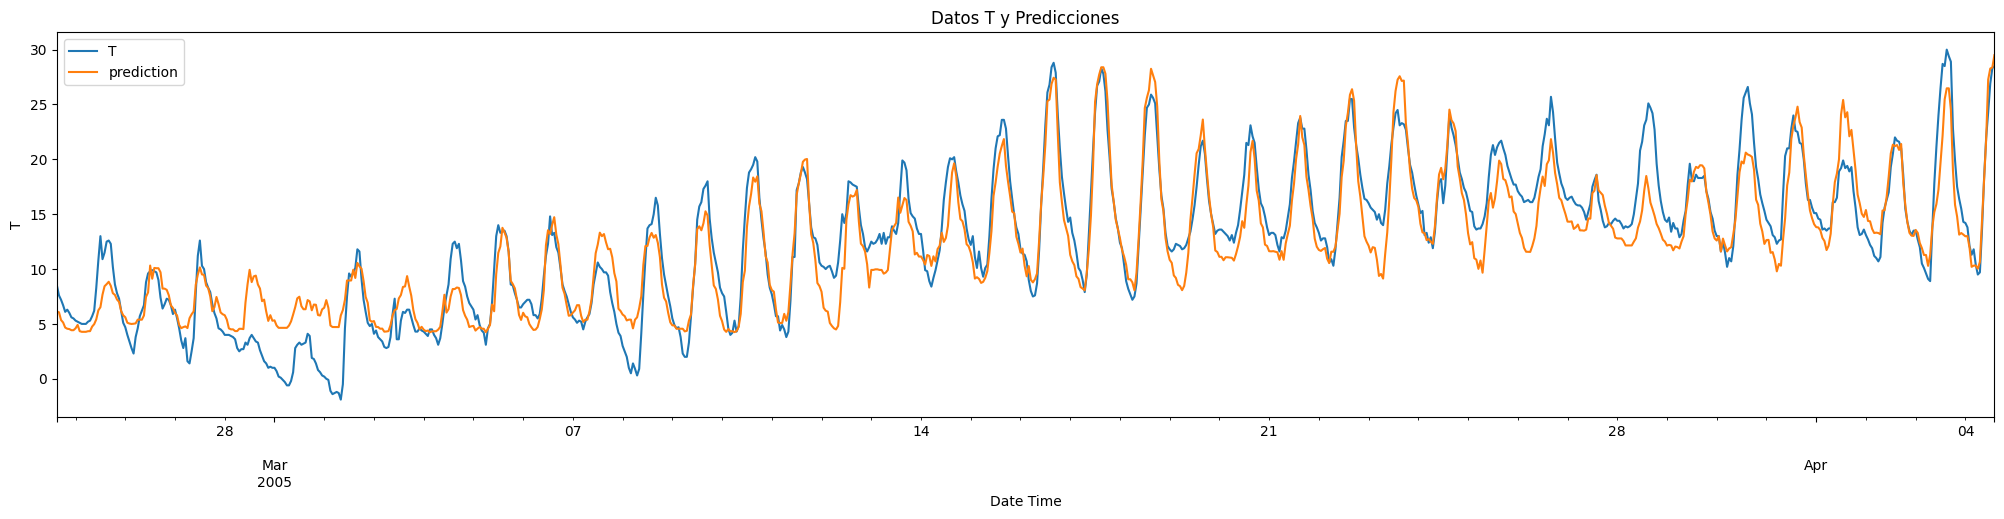

In [230]:
#Gráfica
ax = val.loc[(val.index >= '2005-02-24 15:00:00')]['T'].plot(figsize=(25, 5), title='Datos reales de test y predicciones')
val.loc[(val.index >= '2005-02-24 15:00:00')]['prediction'].plot()
plt.legend(['Datos reales','Predicciones'])

plt.title('Datos T y Predicciones')
plt.legend()

plt.xlabel('Date Time')
plt.ylabel('T')

plt.show()

In [231]:
val['prediction'] = reg.predict(X_val )
val

<ipython-input-231-0912667ba041>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val )


,C6H6,T,RH,hour,dayofweek,year,dayofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,
2005-02-24 15:00:00,10.7,8.5,66.3,15,3,2005,55,5.6,8.9,4.5,6.133223
2005-02-24 16:00:00,13.3,7.6,70.8,16,3,2005,55,5.4,9.0,5.1,6.060047
2005-02-24 17:00:00,13.2,7.2,72.4,17,3,2005,55,4.9,9.3,5.0,5.353911
2005-02-24 18:00:00,17.5,6.7,74.2,18,3,2005,55,4.8,8.4,4.3,5.131666
2005-02-24 19:00:00,17.7,6.1,75.8,19,3,2005,55,4.8,7.6,4.3,4.667797
...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,13.5,21.9,29.3,10,0,2005,94,21.1,17.8,10.0,21.742996
2005-04-04 11:00:00,11.4,24.3,23.7,11,0,2005,94,24.0,20.8,13.0,27.271534
2005-04-04 12:00:00,12.4,26.9,18.3,12,0,2005,94,26.5,21.6,14.0,28.275154


In [232]:
train['prediction'] = reg.predict(X_train)
train

<ipython-input-232-588bb2489198>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prediction'] = reg.predict(X_train)


,C6H6,T,RH,hour,dayofweek,year,dayofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,
2004-03-10 18:00:00,11.9,13.6,48.9,18,2,2004,70,NaN,NaN,NaN,11.316076
2004-03-10 19:00:00,9.4,13.3,47.7,19,2,2004,70,NaN,NaN,NaN,11.369620
2004-03-10 20:00:00,9.0,11.9,54.0,20,2,2004,70,NaN,NaN,NaN,10.604176
2004-03-10 21:00:00,9.2,11.0,60.0,21,2,2004,70,NaN,NaN,NaN,10.475502
2004-03-10 22:00:00,6.5,11.2,59.6,22,2,2004,70,NaN,NaN,NaN,10.207601
...,...,...,...,...,...,...,...,...,...,...,...
2005-02-23 10:00:00,3.8,3.1,83.0,10,2,2005,54,6.1,8.9,8.7,5.343598
2005-02-23 11:00:00,3.6,2.8,83.9,11,2,2005,54,9.1,9.1,10.0,7.233710
2005-02-23 12:00:00,3.7,3.9,79.5,12,2,2005,54,11.4,9.1,11.8,8.235317


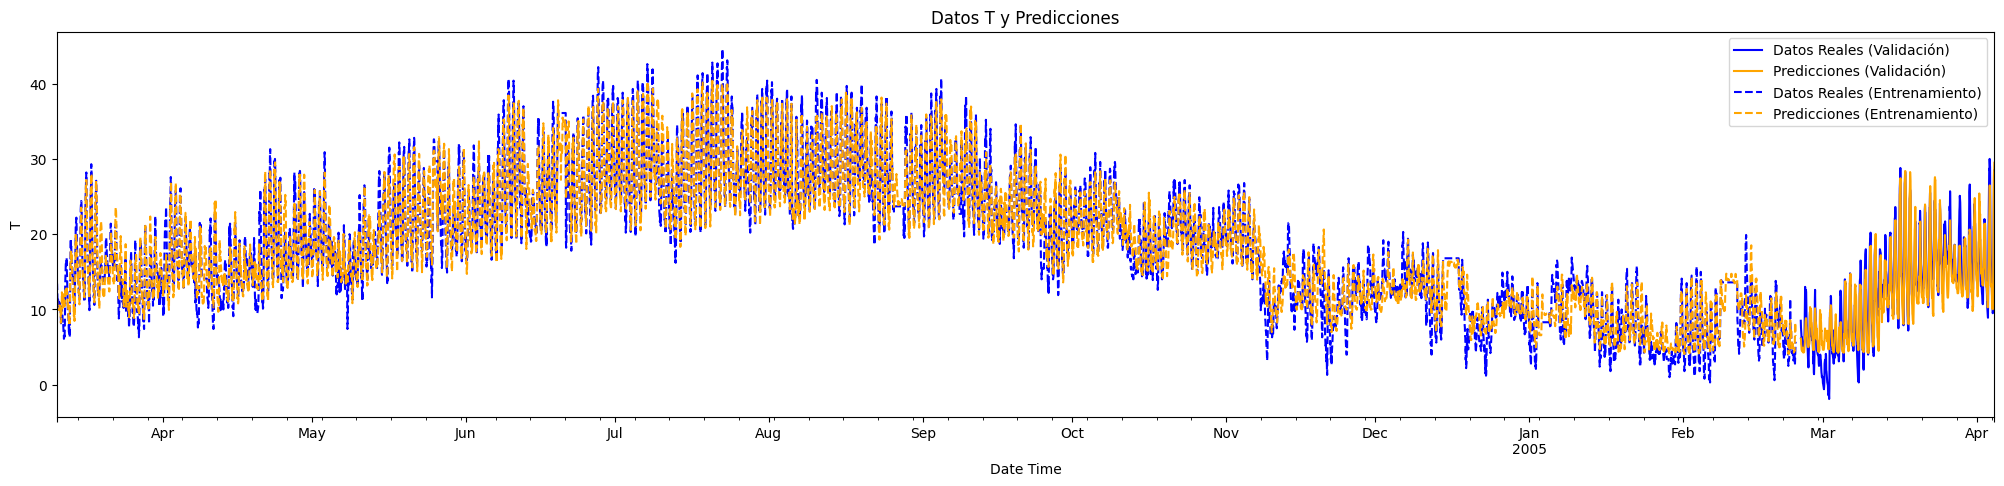

In [233]:
plt.figure(figsize=(25, 5))

# Graficar los datos reales y las predicciones para el DataFrame de validación
ax = val.loc[val.index >= '2005-02-24 15:00:00']['T'].plot(label='Datos Reales (Validación)', color='blue')
val.loc[val.index >= '2005-02-24 15:00:00']['prediction'].plot(ax=ax, label='Predicciones (Validación)', color='orange')

# Graficar los datos reales y las predicciones para el DataFrame de entrenamiento
train.loc[train.index >= '2004-03-10 18:00:00']['T'].plot(ax=ax, label='Datos Reales (Entrenamiento)', color='blue', linestyle='--')
train.loc[train.index >= '2004-03-10 18:00:00']['prediction'].plot(ax=ax, label='Predicciones (Entrenamiento)', color='orange', linestyle='--')

plt.title('Datos T y Predicciones')
plt.legend()

plt.xlabel('Date Time')
plt.ylabel('T')

plt.show()

***Predicción de 24 horas:***

In [234]:
# Último índice en tus datos
last_index = pd.Timestamp('2005-04-04 14:00:00')

In [235]:
# Data frame vacio con el index para los datos futuros
future_dates = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=24, freq='H')

In [236]:
future_df = pd.DataFrame(index=future_dates)

In [237]:
C6H6_futuro = df['C6H6'].mean()
print(C6H6_futuro)

10.190392219728546


In [238]:
RH_futuro = df['RH'].mean()
print(RH_futuro)

48.817430800470234


In [240]:
future_df


,year,dayofweek,dayofyear,hour,C6H6,RH
2005-04-04 15:00:00,2005,0,94,15,10.19,48.81
2005-04-04 16:00:00,2005,0,94,16,10.19,48.81
2005-04-04 17:00:00,2005,0,94,17,10.19,48.81
2005-04-04 18:00:00,2005,0,94,18,10.19,48.81
2005-04-04 19:00:00,2005,0,94,19,10.19,48.81
2005-04-04 20:00:00,2005,0,94,20,10.19,48.81
2005-04-04 21:00:00,2005,0,94,21,10.19,48.81
2005-04-04 22:00:00,2005,0,94,22,10.19,48.81
2005-04-04 23:00:00,2005,0,94,23,10.19,48.81
2005-04-05 00:00:00,2005,1,95,0,10.19,48.81


In [242]:
#Agregar variables al data frame futuro de 24 horas, simular los lags futuros y estimar un valor  futuro para las variables exógenasx
future_df['year'] = future_df.index.year
future_df['dayofweek'] = future_df.index.dayofweek
future_df['dayofyear'] = future_df.index.dayofyear
future_df['hour'] = future_df.index.hour
future_df['C6H6'] = 10.19
future_df['RH'] = 48.81

future_df['lag_24'] = future_df['C6H6'] # Simular valores para lag_24
future_df['lag_168'] = future_df['C6H6'] # Simular valores para lag_168
future_df['lag_720'] = future_df['C6H6'] # Simular valores para lag_720

In [243]:
future_df

,year,dayofweek,dayofyear,hour,C6H6,RH,lag_24,lag_168,lag_720
2005-04-04 15:00:00,2005,0,94,15,10.19,48.81,10.19,10.19,10.19
2005-04-04 16:00:00,2005,0,94,16,10.19,48.81,10.19,10.19,10.19
2005-04-04 17:00:00,2005,0,94,17,10.19,48.81,10.19,10.19,10.19
2005-04-04 18:00:00,2005,0,94,18,10.19,48.81,10.19,10.19,10.19
2005-04-04 19:00:00,2005,0,94,19,10.19,48.81,10.19,10.19,10.19
2005-04-04 20:00:00,2005,0,94,20,10.19,48.81,10.19,10.19,10.19
2005-04-04 21:00:00,2005,0,94,21,10.19,48.81,10.19,10.19,10.19
2005-04-04 22:00:00,2005,0,94,22,10.19,48.81,10.19,10.19,10.19
2005-04-04 23:00:00,2005,0,94,23,10.19,48.81,10.19,10.19,10.19
2005-04-05 00:00:00,2005,1,95,0,10.19,48.81,10.19,10.19,10.19


In [244]:
# Ordenar las columnas para que coincidan con las que espera el modelo
feature_columns = ['dayofyear', 'hour', 'dayofweek', 'year', 'C6H6', 'RH', 'lag_24', 'lag_168', 'lag_720']
future_df = future_df[feature_columns]

In [245]:
future_predictions= reg.predict(future_df)

In [246]:
future_df['prediction'] = future_predictions

<ipython-input-246-67716f2f66a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df['prediction'] = future_predictions


In [247]:
future_df

,dayofyear,hour,dayofweek,year,C6H6,RH,lag_24,lag_168,lag_720,prediction
2005-04-04 15:00:00,94,15,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-04 16:00:00,94,16,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-04 17:00:00,94,17,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-04 18:00:00,94,18,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-04 19:00:00,94,19,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-04 20:00:00,94,20,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-04 21:00:00,94,21,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-04 22:00:00,94,22,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-04 23:00:00,94,23,0,2005,10.19,48.81,10.19,10.19,10.19,11.612746
2005-04-05 00:00:00,95,0,1,2005,10.19,48.81,10.19,10.19,10.19,11.612746


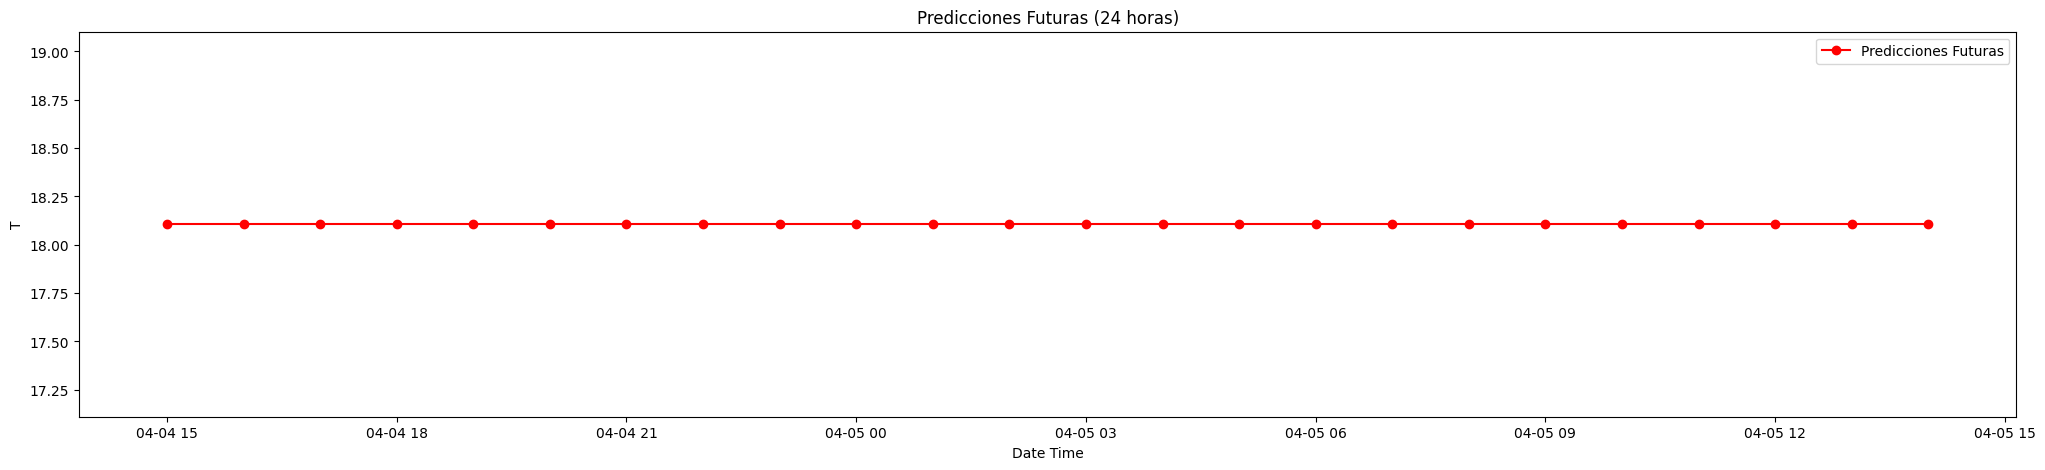

In [59]:
plt.figure(figsize=(25, 5))

# Graficar predicciones futuras
plt.plot(future_df.index, future_df['prediction'], label='Predicciones Futuras',  color='red', marker='o')

plt.title('Predicciones Futuras (24 horas)')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('T')

# Mostrar el gráfico
plt.show()

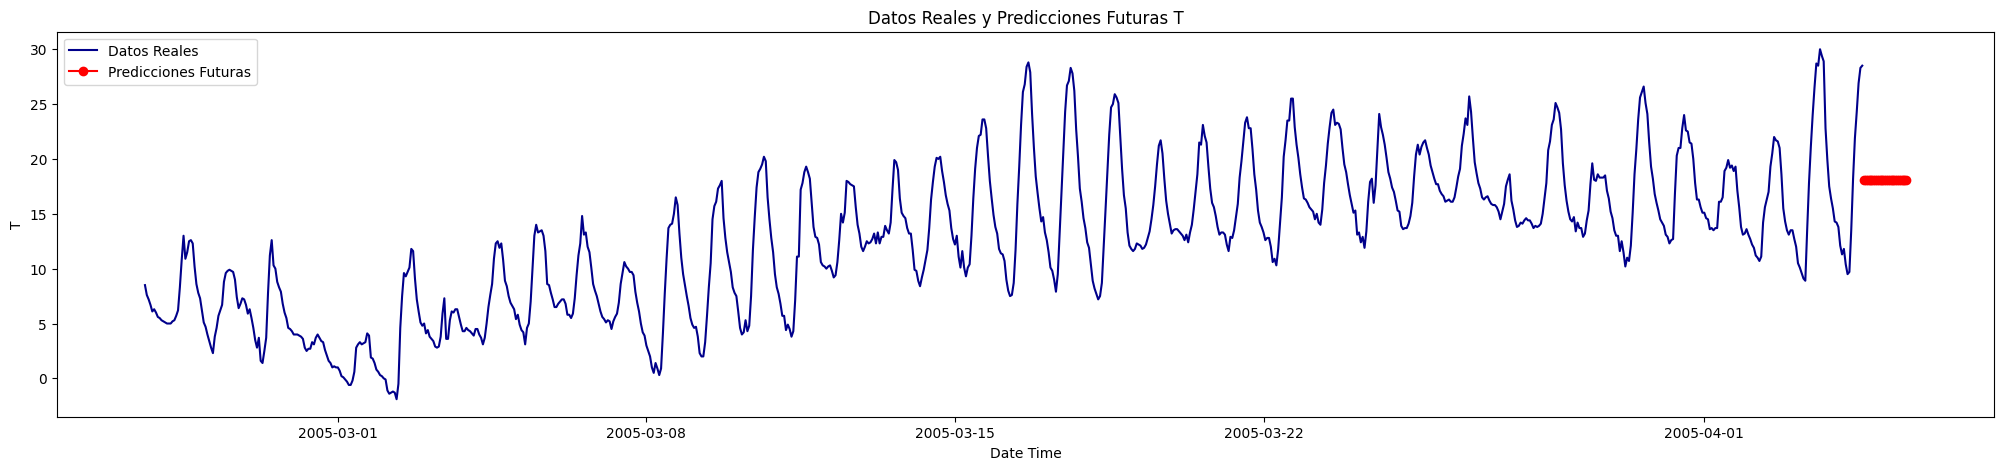

In [60]:
plt.figure(figsize=(25, 5))

plt.plot(val.index, val['T'], label='Datos Reales', color='darkblue')

# Predicciones futuras
plt.plot(future_df.index, future_df['prediction'], label='Predicciones Futuras',  color='red', marker='o')

# Configurar título y leyenda
plt.title('Datos Reales y Predicciones Futuras T')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('T')

# Mostrar el gráfico
plt.show()